**Descrição do Projeto – Modelo de Árvore de Decisão para Detecção de Fraudes**

Este notebook aplica um modelo de Árvore de Decisão para identificar possíveis fraudes em sinistros de seguros. O processo inclui preparação dos dados, divisão entre treino e teste, seleção de hiperparâmetros via GridSearch, avaliação do modelo por métricas como precision, recall, F1-score e AUC-ROC, além da interpretação dos principais fatores que influenciam a decisão do modelo. 

**Objetivo:**  
O objetivo é compreender o comportamento das variáveis e avaliar a capacidade preditiva da Árvore de Decisão na detecção de fraudes.

**Dataset**  
Este conjunto de dados contém informações sobre veículos: atributos, modelo, detalhes de acidentes, etc. Juntamente com detalhes da apólice: tipo de apólice, duração, etc. O objetivo é detectar se uma solicitação de indenização é fraudulenta ou não, variável: FraudFound_P

Dataset: https://www.kaggle.com/datasets/shivamb/vehicle-claim-fraud-detection/data

In [1]:
#Importação dos pacotes necessários

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay
)

import matplotlib.pyplot as plt

In [3]:
# Função Tabela de quantidade (%) para todas as colunas

def resumo_todas_colunas(df):
    resultados = {}

    for col in df.columns:
        # Descrição da coluna
        counts = df[col].value_counts(dropna=False)
        percent = df[col].value_counts(normalize=True, dropna=False) * 100
        
        tabela = pd.DataFrame({
            'quantidade': counts,
            'percentual (%)': percent.round(2)
        })
        
        resultados[col] = tabela
    
    return resultados

In [4]:
#Exportar todas as tabelas (uma por coluna) para Excel

def exportar_resumo_para_excel(resumo_dict, arquivo="resumo.xlsx"):
    with pd.ExcelWriter(arquivo, engine="xlsxwriter") as writer:
        for col, tabela in resumo_dict.items():
            # Nome da aba não pode ter mais que 31 caracteres
            nome_aba = col[:31]
            tabela.to_excel(writer, sheet_name=nome_aba)
    print(f"Arquivo '{arquivo}' criado com sucesso!")

In [5]:
#Converte automaticamente todas as colunas categóricas em dummies.

def transformar_categoricas_em_dummies(df, drop_first=False):
    """
    Converte automaticamente todas as colunas categóricas em dummies.

    - df: DataFrame original
    - drop_first: remove a primeira dummy para evitar multicolinearidade (opcional)

    Retorna:
        novo_df: DataFrame com variáveis dummy
    """
    
    # Identifica colunas categóricas automaticamente
    cols_categoricas = df.select_dtypes(include=['object', 'category']).columns
    
    # Aplica o get_dummies
    df_dummies = pd.get_dummies(df, columns=cols_categoricas, drop_first=drop_first)
    
    return df_dummies


In [81]:
# Rotina para remover automaticamente variáveis com alta colinearidade.

def remover_multicolinearidade(df, limite_corr=0.95):
    """
    Remove automaticamente colunas com colinearidade alta.
    
    Passos:
    1. Remove colunas constantes
    2. Remove colunas com baixa variância (quase constantes)
    3. Remove colunas altamente correlacionadas entre si (> limite_corr)
    
    Retorna:
        df_limpo: DataFrame sem multicolinearidade
        colunas_removidas: lista das colunas eliminadas
    """
    
    df_limpo = df.copy()
    colunas_removidas = []

    # ----------------------------------------------------------------------
    # 1. Remover colunas constantes
    # ----------------------------------------------------------------------
    constantes = [col for col in df_limpo.columns if df_limpo[col].nunique() <= 1]
    
    df_limpo.drop(columns=constantes, inplace=True)
    colunas_removidas.extend(constantes)
    
    
    # ----------------------------------------------------------------------
    # 2. Remover colunas quase constantes (≥ 99% do mesmo valor)
    # ----------------------------------------------------------------------
    quase_constantes = []
    for col in df_limpo.columns:
        freq = df_limpo[col].value_counts(normalize=True, dropna=False)
        if freq.iloc[0] >= 0.99:   # Ajustável
            quase_constantes.append(col)
    
    df_limpo.drop(columns=quase_constantes, inplace=True)
    colunas_removidas.extend(quase_constantes)
    
    
    # ----------------------------------------------------------------------
    # 3. Remover colunas altamente correlacionadas
    # ----------------------------------------------------------------------
    corr = df_limpo.corr().abs()

    upper_tri = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    
    colinearidade_alta = [
        col for col in upper_tri.columns 
        if any(upper_tri[col] > limite_corr)
    ]

    df_limpo.drop(columns=colinearidade_alta, inplace=True)
    colunas_removidas.extend(colinearidade_alta)

    
    # ----------------------------------------------------------------------
    print("🔍 Remoção de multicolinearidade concluída.")
    print(f"➡ Colunas removidas ({len(colunas_removidas)}):")
    for col in colunas_removidas:
        print(" -", col)

    return df_limpo, colunas_removidas

In [71]:
# Importar o banco de dados
    
df = pd.read_csv('fraud_oracle.csv', delimiter=',')

In [72]:
# Visualizando essa base
df.head(3)

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision


In [73]:
# Retornando o shape da base
df.shape

(15420, 33)

In [74]:
#Características das variáveis do dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

In [75]:
#Estatísticas univariadas
df.describe()

,WeekOfMonth,WeekOfMonthClaimed,Age,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Year
count,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000
mean,2.788586,2.693969,39.855707,0.059857,7710.500000,8.483268,407.704280,2.487808,1994.866472
std,1.287585,1.259115,13.492377,0.237230,4451.514911,4.599948,43.950998,1.119453,0.803313
min,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,300.000000,1.000000,1994.000000
25%,2.000000,2.000000,31.000000,0.000000,3855.750000,5.000000,400.000000,1.000000,1994.000000
50%,3.000000,3.000000,38.000000,0.000000,7710.500000,8.000000,400.000000,2.000000,1995.000000
75%,4.000000,4.000000,48.000000,0.000000,11565.250000,12.000000,400.000000,3.000000,1996.000000
max,5.000000,5.000000,80.000000,1.000000,15420.000000,16.000000,700.000000,4.000000,1996.000000


In [76]:
# Análise das 5 ultimas linhas do dataset
df.tail()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
15415,Nov,4,Friday,Toyota,Urban,Tuesday,Nov,5,Male,Married,...,6 years,31 to 35,No,No,External,none,no change,1 vehicle,1996,Collision
15416,Nov,5,Thursday,Pontiac,Urban,Friday,Dec,1,Male,Married,...,6 years,31 to 35,No,No,External,more than 5,no change,3 to 4,1996,Liability
15417,Nov,5,Thursday,Toyota,Rural,Friday,Dec,1,Male,Single,...,5 years,26 to 30,No,No,External,1 to 2,no change,1 vehicle,1996,Collision
15418,Dec,1,Monday,Toyota,Urban,Thursday,Dec,2,Female,Married,...,2 years,31 to 35,No,No,External,more than 5,no change,1 vehicle,1996,All Perils
15419,Dec,2,Wednesday,Toyota,Urban,Thursday,Dec,3,Male,Single,...,5 years,26 to 30,No,No,External,1 to 2,no change,1 vehicle,1996,Collision


In [14]:
# Formato das variaveis
df.dtypes

Month                   object
WeekOfMonth              int64
DayOfWeek               object
Make                    object
AccidentArea            object
DayOfWeekClaimed        object
MonthClaimed            object
WeekOfMonthClaimed       int64
Sex                     object
MaritalStatus           object
Age                      int64
Fault                   object
PolicyType              object
VehicleCategory         object
VehiclePrice            object
FraudFound_P             int64
PolicyNumber             int64
RepNumber                int64
Deductible               int64
DriverRating             int64
Days_Policy_Accident    object
Days_Policy_Claim       object
PastNumberOfClaims      object
AgeOfVehicle            object
AgeOfPolicyHolder       object
PoliceReportFiled       object
WitnessPresent          object
AgentType               object
NumberOfSuppliments     object
AddressChange_Claim     object
NumberOfCars            object
Year                     int64
BasePoli

In [77]:
# Visualizando quantidade de valores vazios
(df.isnull().sum()/df.shape[0]).sort_values(ascending=False).head(20)

Month                   0.0
RepNumber               0.0
Year                    0.0
NumberOfCars            0.0
AddressChange_Claim     0.0
NumberOfSuppliments     0.0
AgentType               0.0
WitnessPresent          0.0
PoliceReportFiled       0.0
AgeOfPolicyHolder       0.0
AgeOfVehicle            0.0
PastNumberOfClaims      0.0
Days_Policy_Claim       0.0
Days_Policy_Accident    0.0
DriverRating            0.0
Deductible              0.0
PolicyNumber            0.0
WeekOfMonth             0.0
FraudFound_P            0.0
VehiclePrice            0.0
dtype: float64

In [78]:
# Tabela de frequências absolutas da variável 'FraudFound_P'

#df['FraudFound_P'].value_counts(dropna=False) * 100
df['FraudFound_P'].value_counts(normalize=True, dropna=False) * 100

FraudFound_P
0    94.014267
1     5.985733
Name: proportion, dtype: float64

In [ ]:
# Executa análise e exporta tabela de Franquencia para Excel
resumo = resumo_todas_colunas(df)

# Exporta
exportar_resumo_para_excel(resumo, "resumo_todas_colunas.xlsx")

Arquivo 'resumo_todas_colunas.xlsx' criado com sucesso!


In [79]:
##DayOfWeekClaimed: Removendo valor 0, onde Identiquei somente 1 caso
df = df[df['DayOfWeekClaimed'] != '0']

#Days_Policy_Accident: Identificado 0,36% de registros = "None"
#Optei por manter os registros, pois em modelos de detecção de fraude costumam considerar missing como uma categoria válida, porque o padrão de ausência pode revelar comportamento fraudulento.


In [82]:
# Criar dummies
# Transformando as variáveis categóricas em dummies
df_dummies = pd.get_dummies(df, drop_first=True)

# Remove colinearidade
df_sem_colinearidade, removidas = remover_multicolinearidade(df_dummies, limite_corr=0.95)

print("Formato original:", df.shape)
print("Dimensão antes:", df_dummies.shape)
print("Dimensão depois:", df_sem_colinearidade.shape)


🔍 Remoção de multicolinearidade concluída.
➡ Colunas removidas (33):
 - Make_BMW
 - Make_Dodge
 - Make_Ferrari
 - Make_Jaguar
 - Make_Lexus
 - Make_Mecedes
 - Make_Mercury
 - Make_Nisson
 - Make_Porche
 - Make_Saab
 - Make_Saturn
 - DayOfWeekClaimed_Saturday
 - DayOfWeekClaimed_Sunday
 - MaritalStatus_Widow
 - PolicyType_Sport - All Perils
 - PolicyType_Sport - Liability
 - PolicyType_Utility - Collision
 - PolicyType_Utility - Liability
 - VehiclePrice_60000 to 69000
 - Days_Policy_Accident_15 to 30
 - Days_Policy_Accident_8 to 15
 - Days_Policy_Accident_none
 - Days_Policy_Claim_8 to 15
 - Days_Policy_Claim_more than 30
 - AgeOfVehicle_3 years
 - AgeOfPolicyHolder_18 to 20
 - AgeOfPolicyHolder_21 to 25
 - WitnessPresent_Yes
 - AddressChange_Claim_under 6 months
 - NumberOfCars_5 to 8
 - NumberOfCars_more than 8
 - MaritalStatus_Single
 - BasePolicy_Liability
Formato original: (15419, 33)
Dimensão antes: (15419, 122)
Dimensão depois: (15419, 89)


In [83]:
# Formato das variaveis transformadas em dummies
df_sem_colinearidade.dtypes

WeekOfMonth                         int64
WeekOfMonthClaimed                  int64
Age                                 int64
FraudFound_P                        int64
PolicyNumber                        int64
                                    ...  
AddressChange_Claim_4 to 8 years     bool
AddressChange_Claim_no change        bool
NumberOfCars_2 vehicles              bool
NumberOfCars_3 to 4                  bool
BasePolicy_Collision                 bool
Length: 89, dtype: object

In [84]:
# converte as colunas bool para int.
df_dummies = df_sem_colinearidade.astype({col: 'int' for col in df_sem_colinearidade.select_dtypes('bool').columns})

#df2['smoker_yes'] = df2['smoker_yes'].astype(int)
#df2['region_northwest'] = df2['region_northwest'].astype(int)
#df2['region_southeast'] = df2['region_southeast'].astype(int)
#df2['region_southwest'] = df2['region_southwest'].astype(int)


In [85]:
# Formato das variaveis transformadas em dummies
df_dummies.dtypes

WeekOfMonth                         int64
WeekOfMonthClaimed                  int64
Age                                 int64
FraudFound_P                        int64
PolicyNumber                        int64
                                    ...  
AddressChange_Claim_4 to 8 years    int64
AddressChange_Claim_no change       int64
NumberOfCars_2 vehicles             int64
NumberOfCars_3 to 4                 int64
BasePolicy_Collision                int64
Length: 89, dtype: object

In [86]:
# Ajustando o nome das colunas para melhor ajuste do modelo
df_dummies.columns = (
    df_dummies.columns
    .str.replace(" ", "_", regex=False)
    .str.replace("-", "_", regex=False)
    .str.replace("/", "_", regex=False)
    .str.replace(".", "_", regex=False)
)

In [87]:
# Validando o nome das variaveis apos ajuste das colunas
df_dummies.dtypes

WeekOfMonth                         int64
WeekOfMonthClaimed                  int64
Age                                 int64
FraudFound_P                        int64
PolicyNumber                        int64
                                    ...  
AddressChange_Claim_4_to_8_years    int64
AddressChange_Claim_no_change       int64
NumberOfCars_2_vehicles             int64
NumberOfCars_3_to_4                 int64
BasePolicy_Collision                int64
Length: 89, dtype: object

In [88]:
# Estimação do modelo

lista_colunas = list(df_dummies.drop(columns=['FraudFound_P']).columns)

formula_dummies_modelo = ' + '.join(lista_colunas)

formula_dummies_modelo = "FraudFound_P ~ " + formula_dummies_modelo

print("Fórmula utilizada: ",formula_dummies_modelo)

Fórmula utilizada:  FraudFound_P ~ WeekOfMonth + WeekOfMonthClaimed + Age + PolicyNumber + RepNumber + Deductible + DriverRating + Year + Month_Aug + Month_Dec + Month_Feb + Month_Jan + Month_Jul + Month_Jun + Month_Mar + Month_May + Month_Nov + Month_Oct + Month_Sep + DayOfWeek_Monday + DayOfWeek_Saturday + DayOfWeek_Sunday + DayOfWeek_Thursday + DayOfWeek_Tuesday + DayOfWeek_Wednesday + Make_Chevrolet + Make_Ford + Make_Honda + Make_Mazda + Make_Pontiac + Make_Toyota + Make_VW + AccidentArea_Urban + DayOfWeekClaimed_Monday + DayOfWeekClaimed_Thursday + DayOfWeekClaimed_Tuesday + DayOfWeekClaimed_Wednesday + MonthClaimed_Aug + MonthClaimed_Dec + MonthClaimed_Feb + MonthClaimed_Jan + MonthClaimed_Jul + MonthClaimed_Jun + MonthClaimed_Mar + MonthClaimed_May + MonthClaimed_Nov + MonthClaimed_Oct + MonthClaimed_Sep + Sex_Male + MaritalStatus_Married + Fault_Third_Party + PolicyType_Sedan___Collision + PolicyType_Sedan___Liability + PolicyType_Sport___Collision + PolicyType_Utility___All_P

### Separação de X e Y

In [89]:
# Separação de X e Y

X = df_dummies.drop("FraudFound_P", axis=1)
y = df_dummies["FraudFound_P"]

### Separação dos Dados (Treino vs. Teste)

In [90]:
# Split

#Divide os dados em treino e teste, garantindo que a proporção das classes
#seja mantida (stratify).

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

### Otimização de Hiperparâmetros com Grid Search

In [91]:
#Executa uma busca de hiperparâmetros usando GridSearchCV para encontrar a 
# melhor árvore de decisão com foco em recall da classe fraude. 
#Em seguida, avalia o modelo ideal nos dados de teste.

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42, class_weight="balanced")

param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_leaf': [1, 5, 10, 20],
    'criterion': ['gini', 'entropy'],
}

grid = GridSearchCV(
    dt,
    param_grid,
    scoring='recall',   # foco em fraude
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Melhores parâmetros:", grid.best_params_)

best_dt = grid.best_estimator_

y_pred = best_dt.predict(X_test)
print(classification_report(y_test, y_pred))



Melhores parâmetros: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1}
              precision    recall  f1-score   support

           0       1.00      0.58      0.73      4349
           1       0.13      0.96      0.22       277

    accuracy                           0.60      4626
   macro avg       0.56      0.77      0.48      4626
weighted avg       0.94      0.60      0.70      4626



**Conclusão:**

A busca de hiperparâmetros identificou um modelo de Árvore de Decisão configurado para **maximizar a capacidade de detecção de fraudes**. Com a combinação ideal encontrada, o modelo atingiu **96% de recall**, garantindo que praticamente todas as fraudes sejam identificadas, alinhado ao objetivo de minimizar perdas financeiras.

Como efeito colateral esperado dessa priorização, há um aumento no número de falsos positivos, refletido na **baixa precisão (13%)**. Isso significa mais casos sendo direcionados para análise manual, porém com a segurança de que **quase nenhuma fraude real é perdida.**

### AUC ROC – Avaliação do Modelo

In [92]:
roc_auc = roc_auc_score(y_test, y_proba)
roc_auc


0.8242020863753068

**Conclusão:** O valor de AUC-ROC igual a 0.82 indica que o modelo possui boa capacidade de discriminar entre sinistros fraudulentos e não fraudulentos, atribuindo scores mais altos a casos de fraude em aproximadamente 82% das comparações aleatórias entre ambas as classes.

### Visualização da Curva ROC

<Figure size 800x600 with 0 Axes>

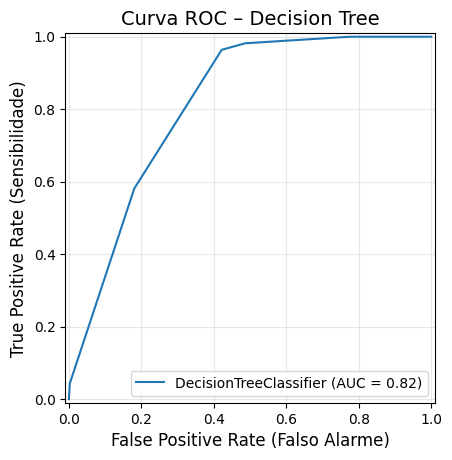

In [93]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))  # aumenta o tamanho do gráfico

RocCurveDisplay.from_estimator(
    best_dt,
    X_test,
    y_test,
    name="DecisionTreeClassifier"
)

plt.title("Curva ROC – Decision Tree", fontsize=14)
plt.xlabel("False Positive Rate (Falso Alarme)", fontsize=12)
plt.ylabel("True Positive Rate (Sensibilidade)", fontsize=12)
plt.grid(alpha=0.3)  # adiciona um grid suave para facilitar leitura
plt.show()


**Conclusão:** o modelo consegue priorizar bem quais sinistros deveriam ser analisados primeiro. Se forem pegos aleatoriamente 1 caso fraudulento e 1 não fraudulento, o modelo tem 82% de chance de colocar a fraude como mais suspeita.

### Visualização da Árvore de Decisão

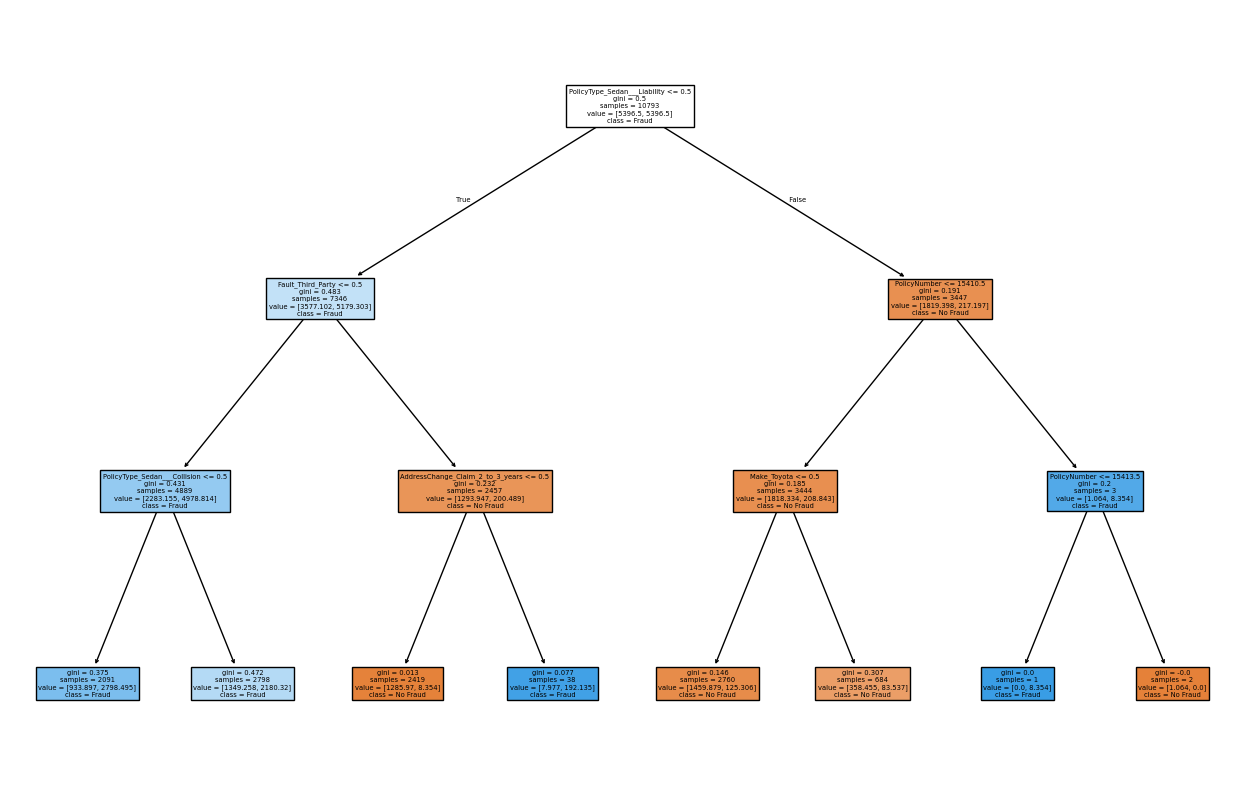

In [60]:
plt.figure(figsize=(16, 10))
plot_tree(
    best_dt,
    feature_names=X.columns,
    class_names=["No Fraud", "Fraud"],
    filled=True,
    max_depth=3
)
plt.show()


### Importância das Variáveis (Feature Importance)

In [94]:
importances = pd.DataFrame({
    "feature": X.columns,
    "importance": best_dt.feature_importances_
}).sort_values("importance", ascending=False)

importances.head(10)


,feature,importance
52,PolicyType_Sedan___Liability,0.402308
50,Fault_Third_Party,0.390375
82,AddressChange_Claim_2_to_3_years,0.163275
51,PolicyType_Sedan___Collision,0.032768
3,PolicyNumber,0.006946
30,Make_Toyota,0.004328
0,WeekOfMonth,0.000000
57,VehiclePrice_30000_to_39000,0.000000
63,PastNumberOfClaims_more_than_4,0.000000
62,PastNumberOfClaims_2_to_4,0.000000


**Conclusão:** A análise de importância das variáveis mostra que o modelo concentra suas decisões principalmente em três fatores: **PolicyType_Sedan___Liability, Fault_Third_Party e AddressChange_Claim_2_to_3_years**, que juntos explicam praticamente todo o poder preditivo da **árvore 95,6%**.  
Esses atributos se destacam como os principais direcionadores na identificação de potenciais fraudes, enquanto as demais variáveis apresentam impacto marginal no processo decisório.

### Avaliação dos Modelos

In [69]:
print("AUC Logistic Regression (Baseline): 0.8065")
print("AUC Decision Tree:", round(roc_auc, 4))


AUC Logistic Regression (Baseline): 0.8065
AUC Decision Tree: 0.8242


**Conclusão – Comparação entre Modelos:**

A comparação via AUC mostra que o modelo de **Árvore de Decisão apresenta melhor desempenho discriminativo** do que a Regressão Logística (0.824 vs. 0.806), o que indica maior eficácia na separação entre sinistros fraudulentos e não fraudulentos. 

Apesar de ambos os modelos performarem bem, a árvore oferece um ganho adicional na detecção de fraude, sugerindo que sua estrutura não linear captura relações que a regressão linear não consegue modelar de forma tão eficiente.

# Fim

### Tabela Interpretativa Automática
Apenas para fins de comparação

In [70]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Gera relatório de classificação em formato de dicionário
report = classification_report(y_test, y_pred, output_dict=True)

# Matriz de confusão
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Cria tabela interpretativa
interpret_table = pd.DataFrame({
    "Metric": ["Precision (Fraude)", "Recall (Fraude)", "F1-Score (Fraude)",
               "Precision (Não Fraude)", "Recall (Não Fraude)", "F1-Score (Não Fraude)",
               "True Positives (TP)", "False Positives (FP)",
               "True Negatives (TN)", "False Negatives (FN)"],
    "Value": [
        report["1"]["precision"], report["1"]["recall"], report["1"]["f1-score"],
        report["0"]["precision"], report["0"]["recall"], report["0"]["f1-score"],
        tp, fp, tn, fn
    ],
    "Interpretation": [
        "Entre as previsões de fraude, quantas são fraude mesmo.",
        "Entre todas as fraudes reais, quantas o modelo encontrou.",
        "Equilíbrio entre precisão e recall para fraude.",
        "Entre previsões de não fraude, quantas estão corretas.",
        "Entre todas as não fraudes reais, quantas foram encontradas.",
        "Equilíbrio entre precisão e recall para não fraude.",
        "Fraudes corretamente detectadas (verdadeiros positivos).",
        "Casos marcados como fraude, mas que não eram (falsos positivos).",
        "Casos corretos de não fraude (verdadeiros negativos).",
        "Fraudes reais que o modelo deixou passar (falsos negativos)."
    ]
})

interpret_table


,Metric,Value,Interpretation
0,Precision (Fraude),0.127082,"Entre as previsões de fraude, quantas são frau..."
1,Recall (Fraude),0.963899,"Entre todas as fraudes reais, quantas o modelo..."
2,F1-Score (Fraude),0.224558,Equilíbrio entre precisão e recall para fraude.
3,Precision (Não Fraude),0.996040,"Entre previsões de não fraude, quantas estão c..."
4,Recall (Não Fraude),0.578294,"Entre todas as não fraudes reais, quantas fora..."
5,F1-Score (Não Fraude),0.731743,Equilíbrio entre precisão e recall para não fr...
6,True Positives (TP),267.000000,Fraudes corretamente detectadas (verdadeiros p...
7,False Positives (FP),1834.000000,"Casos marcados como fraude, mas que não eram (..."
8,True Negatives (TN),2515.000000,Casos corretos de não fraude (verdadeiros nega...
9,False Negatives (FN),10.000000,Fraudes reais que o modelo deixou passar (fals...
